In [35]:
import sys
import random
import xarray as xr
import numpy as np
import os
import yaml
import math
from math import fmod
from datetime import datetime, timedelta
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ParcelsRandom, Variable, Kernel, AdvectionRK4
from cartopy import crs, feature
import zarr 
import matplotlib.pyplot as plt
import pandas as pd
import cmocean.cm as cm

In [36]:
path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
'coords': '/ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
'coordsWW3': '/ocean/vvalenzuela/MOAD/grid2/WW3_grid.nc',
'mask': '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc',
'bat': '/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc',
'out': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs',
'home': '/home/vvalenzuela/MOAD/Ocean_Parcels',
'anim': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs/animations'}
#
coords = xr.open_dataset(path['coords'], decode_times=False)
mask = xr.open_dataset(path['mask'])
bathy = xr.open_dataset(path['bat'])

Testing 10 min, 5 min and 2 min

In [37]:
file_name_10 = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_hourly_V2/PBDEs_run_for_8_days_10_hourly_particles_36000_min_R_interval20220101_1n_20220109_1n.zarr'
file_name_5 = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_hourly_V2/PBDEs_run_for_8_days_10_hourly_particles_18000_min_R_interval20220101_1n_20220109_1n.zarr'
file_name_2 = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Test_runs/Test_hourly_V2/PBDEs_run_for_8_days_10_hourly_particles_7200_min_R_interval20220101_1n_20220109_1n.zarr'

In [38]:
data_10 = xr.open_zarr(file_name_10)
data_5 = xr.open_zarr(file_name_5)
data_2 = xr.open_zarr(file_name_2)

In [39]:
data_10_s4 = data_10.where(data_10['status'] == 4)
per_10_s4 = (np.sum(~np.isnan(data_10_s4.status.values.ravel())) / len(data_10.status.values.ravel())) * 100
#
data_5_s4 = data_5.where(data_5['status'] == 4)
per_5_s4 = (np.sum(~np.isnan(data_5_s4.status.values.ravel())) / len(data_5.status.values.ravel())) * 100
#
data_2_s4 = data_2.where(data_2['status'] == 4)
per_2_s4 = (np.sum(~np.isnan(data_2_s4.status.values.ravel())) / len(data_2.status.values.ravel())) * 100
#
print(f'Percentage of Status 4 for Resuspension interval of 10 min: {per_10_s4:.2f} %')
print(f'Percentage of Status 4 for Resuspension interval of 5 min: {per_5_s4:.2f} %')
print(f'Percentage of Status 4 for Resuspension interval of 2 min: {per_2_s4:.2f} %')

Percentage of Status 4 for Resuspension interval of 10 min: 50.19 %
Percentage of Status 4 for Resuspension interval of 5 min: 50.46 %
Percentage of Status 4 for Resuspension interval of 2 min: 45.73 %


In [40]:
s4_10 = []
s4_5 = []
s4_2 = []
total = []
for i in range(0,len(data_10.obs)):
    len_10_s4 = len(np.where(np.isfinite(data_10.status[:, i]) & (data_10.status[:, i] == 4.))[0])
    len_5_s4 = len(np.where(np.isfinite(data_5.status[:, i]) & (data_5.status[:, i] == 4.))[0])
    len_2_s4 = len(np.where(np.isfinite(data_2.status[:, i]) & (data_2.status[:, i] == 4.))[0])
    len_T = np.count_nonzero(~np.isnan(data_10.status[:, i]))
    #
    s4_10.append(len_10_s4)
    s4_5.append(len_5_s4)
    s4_2.append(len_2_s4)
    total.append(len_T)
proportion_10min = np.array(s4_10)/np.array(total)
proportion_5min = np.array(s4_5)/np.array(total)
proportion_2min = np.array(s4_2)/np.array(total)    


Text(0.75, 0.95, 'Avg. 10 min R.I. 50.19 %\nAvg. 5 min R.I. 50.46 %\nAvg. 2 min R.I. 45.73 %\n')

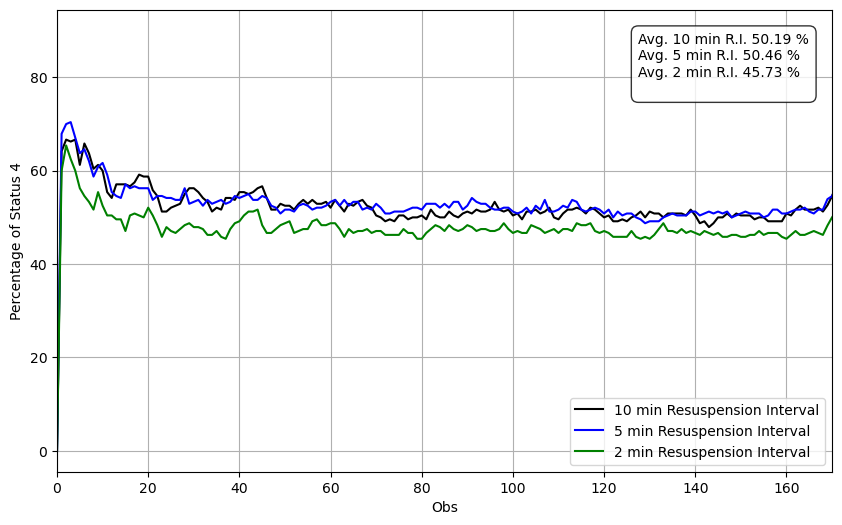

In [41]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(proportion_10min*100, 'k', label = '10 min Resuspension Interval')
ax.plot(proportion_5min*100, 'b', label = '5 min Resuspension Interval')
ax.plot(proportion_2min*100, 'g', label = '2 min Resuspension Interval')
#
ax.legend(loc='lower right')
ax.grid()
ax.set_ylabel('Percentage of Status 4')
ax.set_xlabel('Obs')
#
ax.set_xlim([0,170])
#
percentage_text = (
    f"Avg. 10 min R.I. {per_10_s4:.2f} %\n"
    f"Avg. 5 min R.I. {per_5_s4:.2f} %\n"
    f"Avg. 2 min R.I. {per_2_s4:.2f} %\n"
)
#
ax.text(0.75, 0.95, percentage_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

In [42]:
def particles_concentration_map(lons, lats, mask=mask, num_lon=30, num_lat=40):
    # Define lon and lat lenght 
    longitudes = np.linspace(mask['nav_lon'].min(), mask['nav_lon'].max(), num_lon + 1)
    latitudes = np.linspace(mask['nav_lat'].min(), mask['nav_lat'].max(), num_lat + 1)
    #
    # Particle positions into bins
    lon_indices = np.digitize(lons, longitudes) - 1 
    lat_indices = np.digitize(lats, latitudes) - 1
    #
    amount = np.zeros((num_lon, num_lat))
    #
    valid_mask = (lon_indices >= 0) & (lon_indices < num_lon) & (lat_indices >= 0) & (lat_indices < num_lat)
    lon_indices, lat_indices = lon_indices[valid_mask], lat_indices[valid_mask]
    # Count particles 
    indices = np.ravel_multi_index((lon_indices, lat_indices), dims=(num_lon, num_lat))
    counts = np.bincount(indices, minlength=num_lon * num_lat).reshape((num_lon, num_lat))
    #
    amount[:counts.shape[0], :counts.shape[1]] = counts
    #
    return pd.DataFrame(amount)

In [43]:
concentration_s4_10 = particles_concentration_map(lons=data_10.where(data_10['status'] == 4)['lon'], lats=data_10.where(data_10['status'] == 4)['lat'])
concentration_s4_5 = particles_concentration_map(lons=data_5.where(data_5['status'] == 4)['lon'], lats=data_5.where(data_5['status'] == 4)['lat'])
concentration_s4_2 = particles_concentration_map(lons=data_2.where(data_2['status'] == 4)['lon'], lats=data_2.where(data_2['status'] == 4)['lat'])

In [44]:
clat = [49.195045]
clon = [-123.301956]
num_lon = 30
num_lat = 40
longitudes = np.linspace(mask['nav_lon'].min(), mask['nav_lon'].max(), num_lon+1)
latitudes = np.linspace(mask['nav_lat'].min(), mask['nav_lat'].max(), num_lat+1)

/tmp/ipykernel_2721861/888419027.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[0].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
/tmp/ipykernel_2721861/888419027.py:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[1].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
/tmp/ipykernel_2721861/888419027.py:31: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, pleas

Text(0.5, 0, 'Longitude')

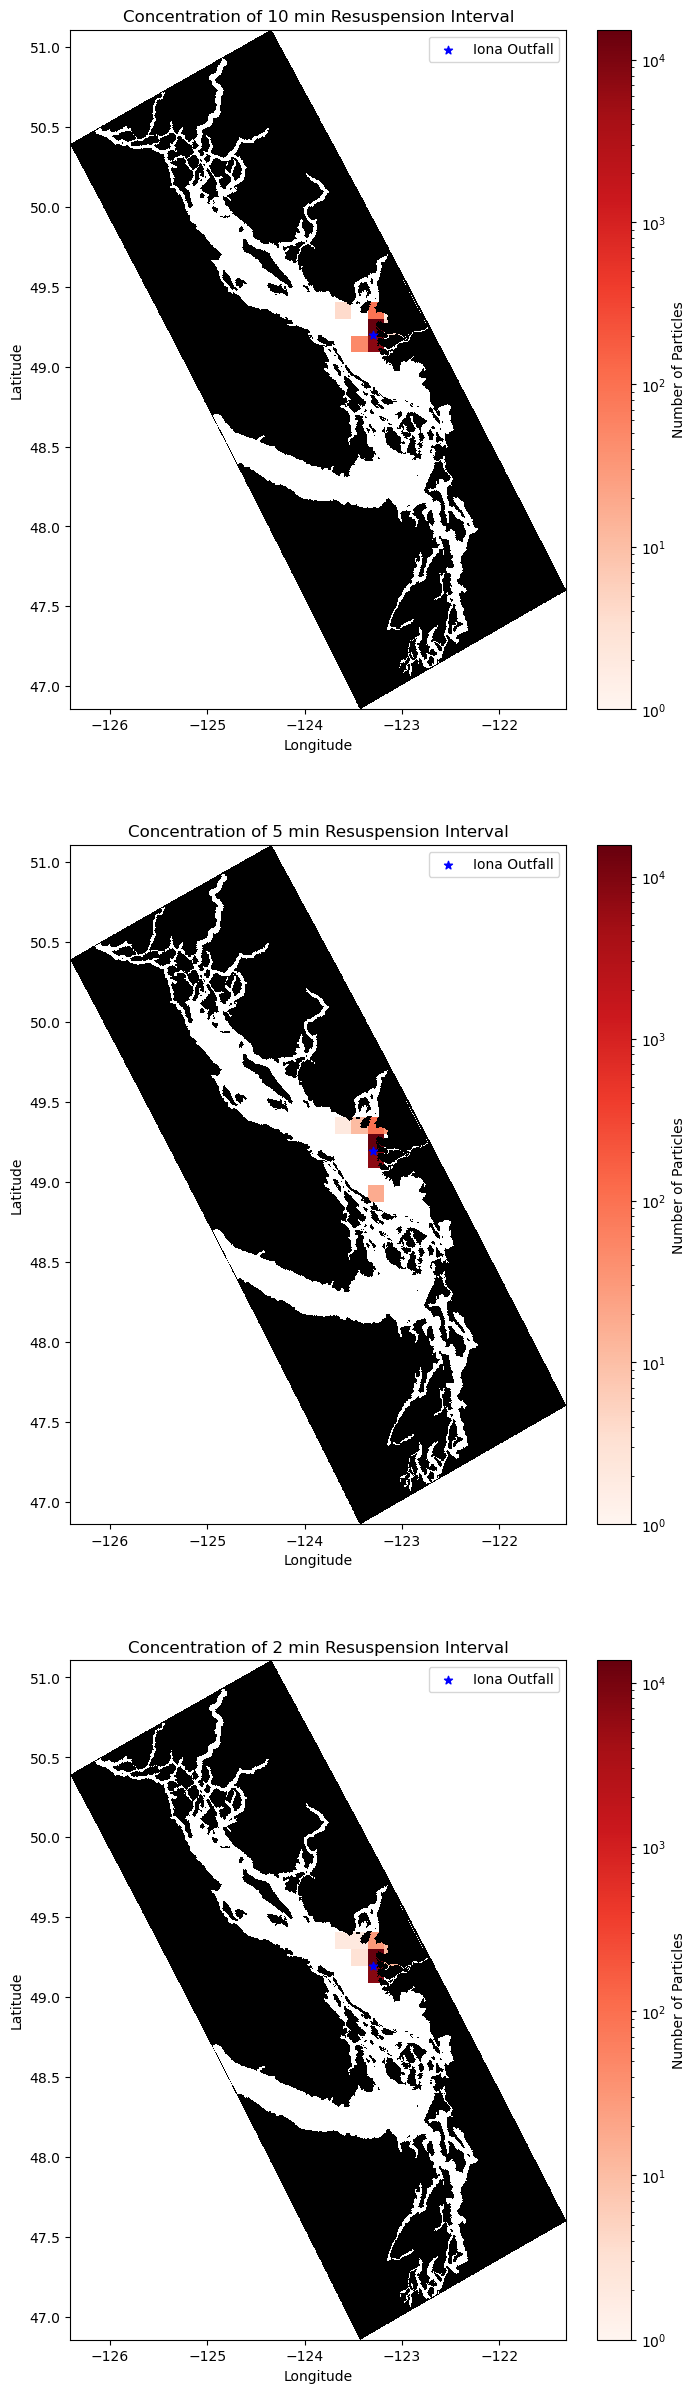

In [45]:
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
#
colors = [(0, 0, 0, 1),  # Black for land (1)
          (0, 0, 0, 0)]  # Transparent for water (0)
cmap = ListedColormap(colors)
#

#
fig, ax = plt.subplots(3,1,figsize=(8,30))
#
min_10 = ax[0].pcolormesh(longitudes, latitudes, concentration_s4_10.T, cmap='Reds', norm=LogNorm(vmin=concentration_s4_10.min().min()+1, vmax=concentration_s4_10.max().max()))
ax[0].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
ax[0].scatter(clon,clat, c = 'b', marker = '*', label = 'Iona Outfall')
fig.colorbar(min_10, ax=ax[0], label="Number of Particles")
ax[0].legend()
ax[0].set_title('Concentration of 10 min Resuspension Interval')
ax[0].set_ylabel('Latitude')
ax[0].set_xlabel('Longitude')
#
min_5 = ax[1].pcolormesh(longitudes, latitudes, concentration_s4_5.T, cmap='Reds', norm=LogNorm(vmin=concentration_s4_5.min().min()+1, vmax=concentration_s4_5.max().max()))
ax[1].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
ax[1].scatter(clon,clat, c = 'b', marker = '*', label = 'Iona Outfall')
fig.colorbar(min_5, ax=ax[1], label="Number of Particles")
ax[1].legend()
ax[1].set_title('Concentration of 5 min Resuspension Interval')
ax[1].set_ylabel('Latitude')
ax[1].set_xlabel('Longitude')
#
min_2 = ax[2].pcolormesh(longitudes, latitudes, concentration_s4_2.T, cmap='Reds', norm=LogNorm(vmin=concentration_s4_2.min().min()+1, vmax=concentration_s4_2.max().max()))
ax[2].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
ax[2].scatter(clon,clat, c = 'b', marker = '*', label = 'Iona Outfall')
fig.colorbar(min_2, ax=ax[2], label="Number of Particles")
ax[2].legend()
ax[2].set_title('Concentration of 2 min Resuspension Interval')
ax[2].set_ylabel('Latitude')
ax[2].set_xlabel('Longitude')


In [46]:
depth_10 = data_10.z/data_10.fact
depth_5 = data_5.z/data_5.fact
depth_2 = data_2.z/data_2.fact

In [47]:
clon

[-123.301956]

/tmp/ipykernel_2721861/654899156.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[0].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
/tmp/ipykernel_2721861/654899156.py:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[1].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
/tmp/ipykernel_2721861/654899156.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please

(48.495045, 49.895045)

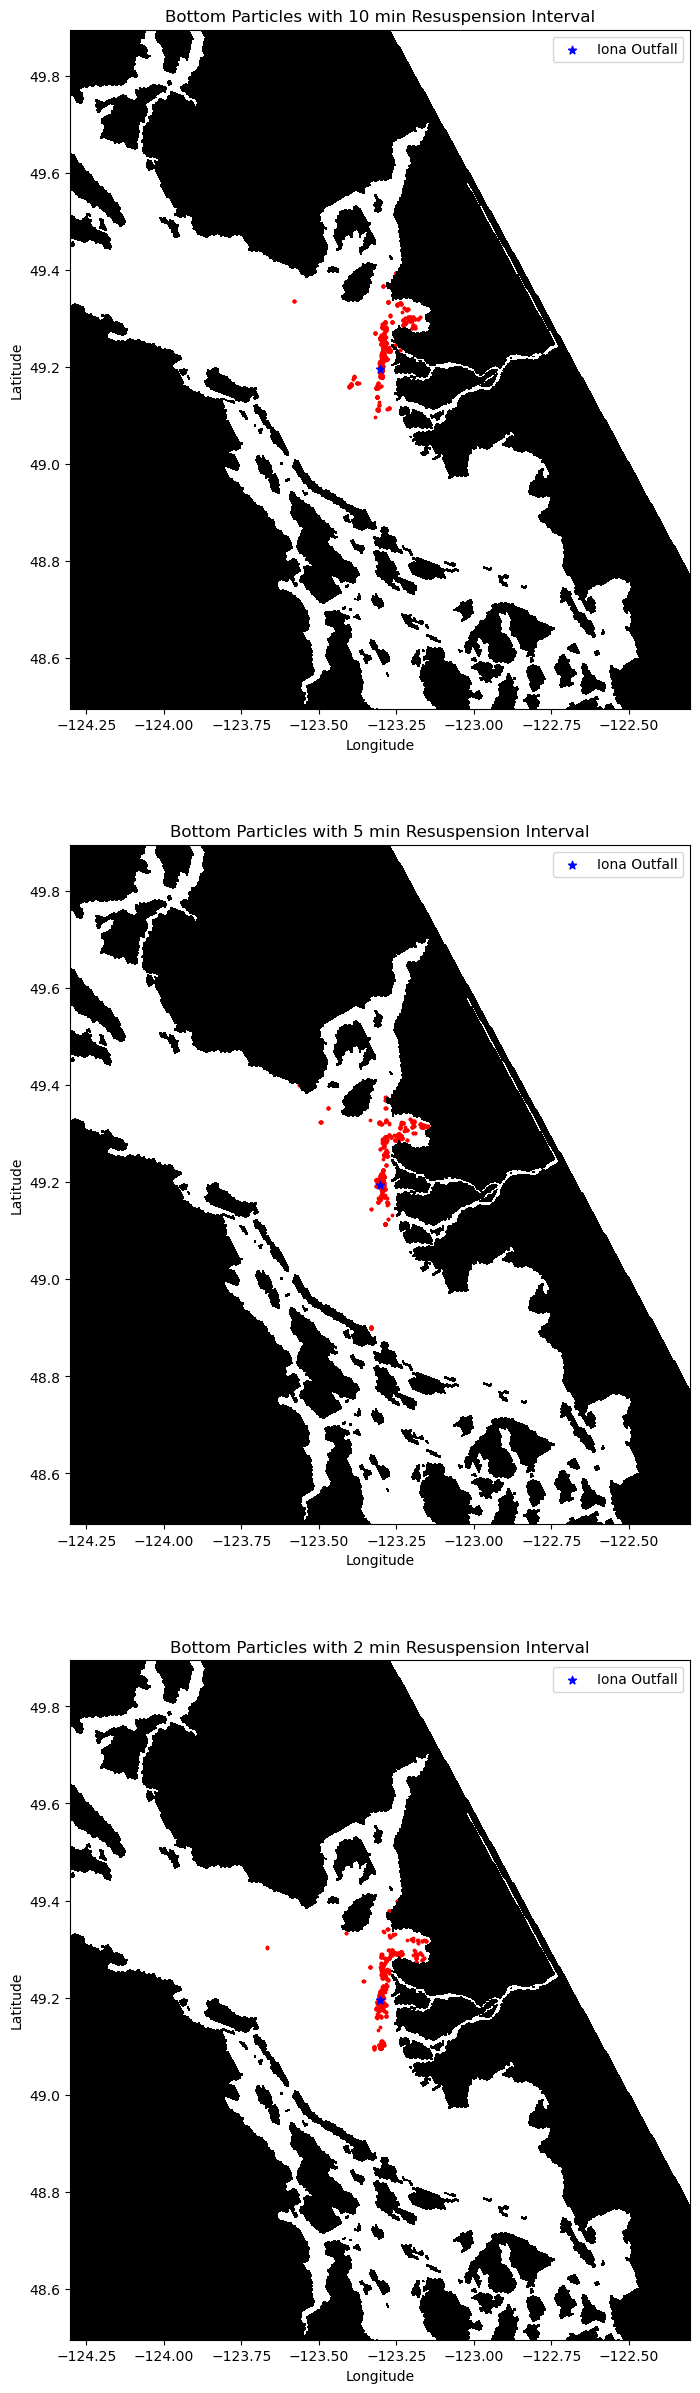

In [48]:
fig, ax = plt.subplots(3,1,figsize=(8,30))
#
min_10 = ax[0].scatter(data_10.where(data_10.status ==4).lon, data_10.where(data_10.status ==4).lat, c='r', s = 3)
ax[0].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
ax[0].scatter(clon,clat, c = 'b', marker = '*', label = 'Iona Outfall')
ax[0].legend()
ax[0].set_title('Bottom Particles with 10 min Resuspension Interval')
ax[0].set_ylabel('Latitude')
ax[0].set_xlabel('Longitude')
ax[0].set_xlim([clon[0] - 1, clon[0] + 1])
ax[0].set_ylim([clat[0] - .7, clat[0] + .7])
#
min_5 = ax[1].scatter(data_5.where(data_5.status ==4).lon, data_5.where(data_5.status ==4).lat, c='r', s = 3)
ax[1].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
ax[1].scatter(clon,clat, c = 'b', marker = '*', label = 'Iona Outfall')
ax[1].legend()
ax[1].set_title('Bottom Particles with 5 min Resuspension Interval')
ax[1].set_ylabel('Latitude')
ax[1].set_xlabel('Longitude')
ax[1].set_xlim([clon[0] - 1, clon[0] + 1])
ax[1].set_ylim([clat[0] - .7, clat[0] + .7])
#
min_2 = ax[2].scatter(data_2.where(data_2.status ==4).lon, data_2.where(data_2.status ==4).lat, c='r', s = 3)
ax[2].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
ax[2].scatter(clon,clat, c = 'b', marker = '*', label = 'Iona Outfall')
ax[2].legend()
ax[2].set_title('Bottom Particles with 2 min Resuspension Interval')
ax[2].set_ylabel('Latitude')
ax[2].set_xlabel('Longitude')
ax[2].set_xlim([clon[0] - 1, clon[0] + 1])
ax[2].set_ylim([clat[0] - .7, clat[0] + .7])